In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
from tqdm import tqdm
import os

%matplotlib inline


In [5]:
# specify the path and name of the zip file
zip_path1 = "/content/drive/MyDrive/Colab Notebooks/data.zip"

# specify the path where you want to extract the contents of the zip file
extract_path1 = "/content"

# create a ZipFile object
with zipfile.ZipFile(zip_path1, 'r') as zip_ref:
    # extract all the contents of the zip file to the specified path
    zip_ref.extractall(extract_path1)

In [6]:
import os
import sys
import shutil
import tempfile

from urllib.request import urlretrieve

# Data directory. Change this to download to a different directory, e.g. to an external drive to save space. 
# You need 20 GB to store all data.
# If you use Google Colab to run this notebook, then you may want to point this to a Google Drive directory shared
# between you and your assignment partner.
dir_data = "/content/data"

# URLs to retrieve ground truth and images data from. 
url_truth = 'https://flux127120.nbw.tue.nl/index.php/s/Cwxa5Ft2pQBK9N7/download'
dir_truth = os.path.join(dir_data, "gtFine")

url_input = 'https://flux127120.nbw.tue.nl/index.php/s/Tz3GCjQwwsiHgqC/download'
dir_input = os.path.join(dir_data, "leftImg8bit")

# Download and extraction function
def download_extract(url: str):
    # Create a temp directory to download into
    with tempfile.TemporaryDirectory(dir=dir_data, prefix="download_") as dir_temp:
        print(f'Downloading: {url}')
        zip_path = os.path.join(dir_temp, 'download.zip')
        urlretrieve(url, zip_path, lambda n, size, total: sys.stdout.write(f'\rProgress: {n*size/total*100:.2f} %'))
        sys.stdout.write('\n')
        sys.stdout.flush()

        print(f'Unpacking archive.')
        shutil.unpack_archive(zip_path, dir_data)

# Create the data directory (if it does not exist)
os.makedirs(dir_data, exist_ok=True)

# Check if both the ground truth and input directories have been downloaded and extracted
for dir, url in [(dir_truth, url_truth), (dir_input, url_input)]:
    if not os.path.isdir(dir):
        # Download the required files
        print(f'Directory does not exist: {dir}')
        download_extract(url)
    else:
        print(f'Directory already downloaded: {dir}')

# Done!
print(f'All data downloaded')



Directory already downloaded: /content/data/gtFine
Directory already downloaded: /content/data/leftImg8bit
All data downloaded


In [7]:
from PIL import Image

# Target size of each sample in the dataset
sample_size = (512, 512)

# Directories for preprocessed datasets
dir_truth_pp, dir_input_pp = (f'{d}_{sample_size[0]}_{sample_size[1]}' for d in (dir_truth, dir_input))

# Run preprocessing
for dir_full, dir_pp in ((dir_truth, dir_truth_pp), (dir_input, dir_input_pp)):
    # Check if the directory already exists
    if os.path.isdir(dir_pp):
        print(f'Preprocessed directory already exists: {dir_pp}')
        continue

    print(f'Preprocessing: {dir_full}')

    # Walk though the directory and preprocess each file 
    for root,_,files in  os.walk( dir_full ):
        if len(files) == 0:
            continue

        print(f'Preprocessing sub-directory: {root.replace(dir_full, "")}')

        # Create the directory in the preprocessed set
        root_pp = root.replace(dir_full, dir_pp)
        os.makedirs(root_pp, exist_ok=True)

        for f in files:
            if not f.endswith('.png'):
                continue

            # Resize and save PNG image
            path_original = os.path.join(root,f)
            img_resized = Image.open(path_original).resize(sample_size, Image.NEAREST)
            img_resized.save(path_original.replace(dir_full, dir_pp), 'png', quality=100)

print(f'Preprocessing done')


Preprocessed directory already exists: /content/data/gtFine_512_512
Preprocessed directory already exists: /content/data/leftImg8bit_512_512
Preprocessing done


In [8]:
from dataclasses import dataclass
from typing import Tuple
import re

# Each sample we downloaded can be identified by the name of the city as well as a frame and sequence id
@dataclass
class CityscapesSample:
    city: str
    seq_id: str
    frame_id: str

    @property
    def id(self):
        return os.path.join(self.city, "_".join([self.city, self.seq_id, self.frame_id]))

    @staticmethod
    def from_filename(filename: str):
        # Create a CityscapesSample from a filename, which has a fixed structure {city}_{sequence}_{frame}
        match = re.match(r"^(\w+)_(\d+)_(\d+).*.png$", filename, re.I)
        return CityscapesSample(match.group(1), match.group(2), match.group(3))


# Each class that we aim to detect is assigned a name, id and color.
@dataclass
class CityscapesClass:
    name: str       # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    ID: int         # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    trainId: int    # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    category: str   # The name of the category that this label belongs to

    categoryId: int # The ID of this category. Used to create ground truth images
                    # on category level.

    hasInstances: bool # Whether this label distinguishes between single instances or not

    ignoreInEval: bool # Whether pixels having this class as ground truth label are ignored
                       # during evaluations or not

    color: Tuple[int, int, int]       # The color of this label


# List of classes that we want to detect in the input
classes = [
    #                 name                     ID    trainId   category            catId     hasInstances   ignoreInEval   color
    CityscapesClass(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    CityscapesClass(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    CityscapesClass(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    CityscapesClass(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    CityscapesClass(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    CityscapesClass(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    CityscapesClass(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    CityscapesClass(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    CityscapesClass(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    CityscapesClass(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    CityscapesClass(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    CityscapesClass(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    CityscapesClass(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    CityscapesClass(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (0  ,  0,  0) ),
    CityscapesClass(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    CityscapesClass(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    CityscapesClass(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    CityscapesClass(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    CityscapesClass(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    CityscapesClass(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    CityscapesClass(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    CityscapesClass(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    CityscapesClass(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    CityscapesClass(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    CityscapesClass(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    CityscapesClass(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    CityscapesClass(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    CityscapesClass(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    CityscapesClass(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    CityscapesClass(  'license plate'        , -1 ,      255 , 'vehicle'         , 7       , False        , True         , (0  ,0  ,  0) ),
]


In [9]:
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, Optional, Tuple, List
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import ConcatDataset

class CityscapesDataset(Dataset):
    # Regular expression matching each PNG file in the dataset
    __read_reg = r"^(\w+)_(\d+)_(\d+).*.png$"

    def __init__(self, dir_input: str, dir_truth: str, sample_size: Tuple[int,int], classes: List[CityscapesSample]):
        super().__init__()

        # These variables are also available as globals, but it is good practice to make classes
        # not depend on global variables.
        self.dir_input = dir_input
        self.dir_truth = dir_truth
        self.sample_size = sample_size
        self.classes = classes

        # Walk through the inputs directory and add each file to our items list
        self.items = []
        for (_, _, filenames) in os.walk(self.dir_input):
            self.items.extend([CityscapesSample.from_filename(f) for f in filenames])

        # Sanity check: do the provided directories contain any samples?
        assert len(self.items) > 0, f"No items found in {self.dir_input}"

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i: int) -> (torch.Tensor, torch.Tensor):
        sample = self.items[i]

        input = self.load_input(sample)
        truth = self.load_truth(sample)

        return self.transform(input, truth)

    def load_input(self, sample: CityscapesSample) -> Image:
        path = os.path.join(self.dir_input, f'{sample.id}_leftImg8bit.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def load_truth(self, sample:CityscapesSample) -> Image:
        path = os.path.join(self.dir_truth, f'{sample.id}_gtFine_color.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def transform(self, img: Image.Image, mask: Optional[Image.Image]) -> (torch.Tensor, torch.Tensor):
        ## EXERCISE #####################################################################
        #
        # Data augmentation is a way to improve the accuracy of a model.
        #
        # Once you have a model that works, you can implement some data augmentation 
        # techniques here to further improve performance.
        #
        ##################################################################################
        # pass
        # horizonal flip
        if np.random.random() < 0.8:
            img = TF.hflip(img)
            mask = TF.hflip(mask)
        #vertical flip
        if np.random.random() < 0.8:
            img = TF.vflip(img)
            mask = TF.vflip(mask)
        #RandomResizeCrop
        if np.random.random() < 0.8:
            width0 = np.random.randint(0,sample_size[0]/2)
            height0 = np.random.randint(0,sample_size[1]/2)
            width1 = np.random.randint((sample_size[0]-width0)/8,sample_size[0]-width0)
            height1 = np.random.randint((sample_size[1]-height0)/8,sample_size[1]-height0)
            img = TF.resized_crop(img,height0,width0,height1,width1,size = (sample_size[1],sample_size[0]),interpolation = T.InterpolationMode.BILINEAR)
            mask = TF.resized_crop(mask,height0,width0,height1,width1,size = (sample_size[1],sample_size[0]),interpolation = T.InterpolationMode.NEAREST)

        if np.random.random() < 0.8:
            angle = np.random.uniform(-16, 16)
            img = TF.rotate(img,angle,interpolation = T.InterpolationMode.BILINEAR)
            mask = TF.rotate(mask,angle,interpolation = T.InterpolationMode.NEAREST)
        img = T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2)(img)



        ################################################################################# 

        # Convert the image to a tensor
        img = TF.to_tensor(img)

        # If no mask is provided, then return only the image
        if mask is None:
            return img, None

        # Transform the mask from an image with RGB-colors to an 1-channel image with the index of the class as value
        mask_size = [s for s in self.sample_size]
        mask = torch.from_numpy(np.array(mask)).permute((2,0,1))
        target = torch.zeros((mask_size[1], mask_size[0]), dtype=torch.uint8)
        for i,c in enumerate(classes):
            eq = mask[0].eq(c.color[0]) & mask[1].eq(c.color[1]) & mask[2].eq(c.color[2])
            target[eq] = c.trainId    
            
        return img, target

    def masks_to_indices(self, masks: torch.Tensor) -> torch.Tensor:
        _, indices = masks.softmax(dim=1).max(dim=1)
        return indices

    def to_image(self, indices: torch.Tensor) -> Image.Image:
        target = torch.zeros((3, indices.shape[0], indices.shape[1]),
                             dtype=torch.uint8, device=indices.device, requires_grad=False)

        for i, lbl in enumerate(self.classes):
            eq = indices.eq(lbl.trainId)

            target[0][eq] = lbl.color[0]
            target[1][eq] = lbl.color[1]
            target[2][eq] = lbl.color[2]

        return TF.to_pil_image(target.cpu(), 'RGB')

# Combine the train sets and create the corresponding set
train_full = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes)
    for name in ("train", "train_night", "train_snow", "train_wet")
}

ds_train_full = [train_full['train'],train_full['train_night'],train_full['train_snow'],train_full['train_wet']]
train_set = ConcatDataset(ds_train_full) 

ds_split = {
   'train':train_set,
   'val':CityscapesDataset(os.path.join(dir_input_pp,'val'),os.path.join(dir_truth_pp,'val'), sample_size, classes),
   'test':CityscapesDataset(os.path.join(dir_input_pp,'test'),os.path.join(dir_truth_pp,'test'), sample_size, classes),
}

Subset,Amount,Size,Input sample,Truth sample
train,11900,512×512,,
val,267,512×512,,
test,544,512×512,,

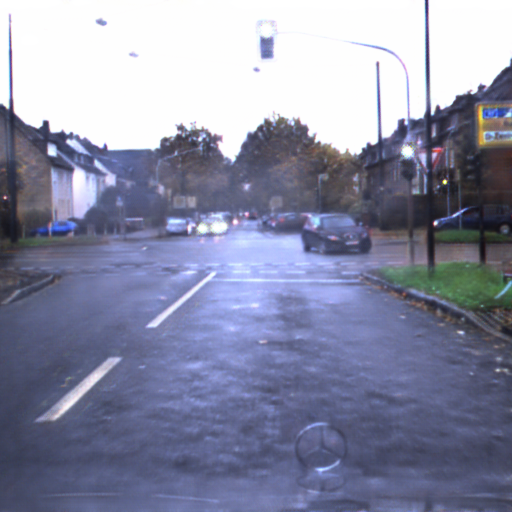
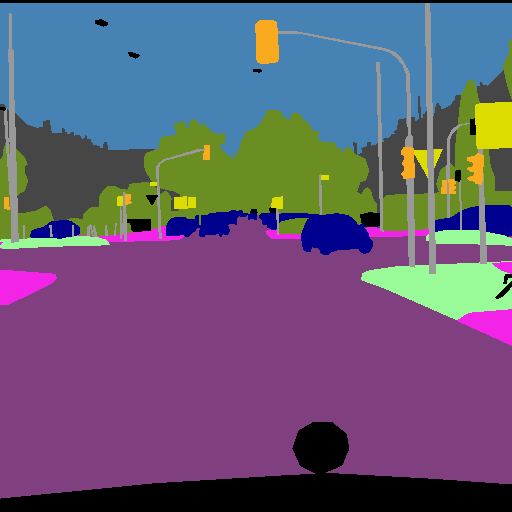
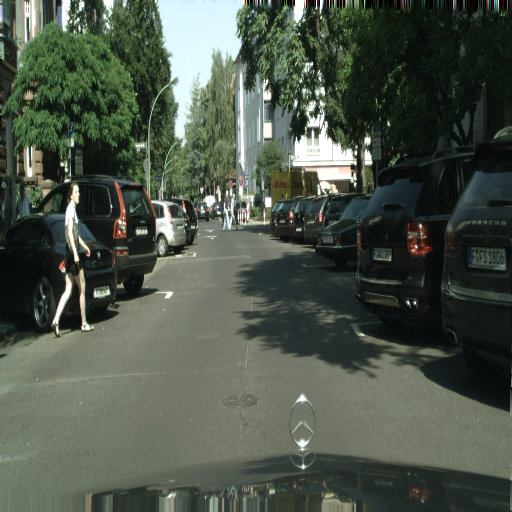
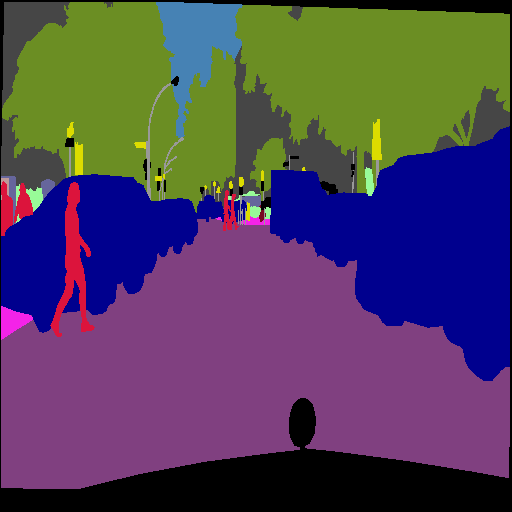
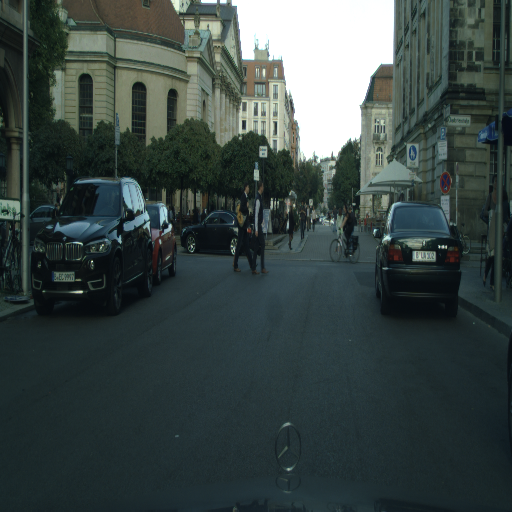
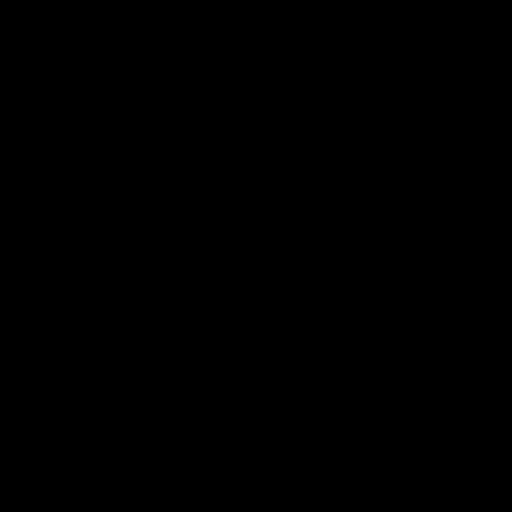

In [44]:
from IPython.display import display, HTML
from io import BytesIO
from base64 import b64encode

import random

def to_image(indices: torch.Tensor) -> Image.Image:
        target = torch.zeros((3, indices.shape[0], indices.shape[1]),
                             dtype=torch.uint8, device=indices.device, requires_grad=False)

        for i, lbl in enumerate(classes):
            eq = indices.eq(lbl.trainId)

            target[0][eq] = lbl.color[0]
            target[1][eq] = lbl.color[1]
            target[2][eq] = lbl.color[2]

        return TF.to_pil_image(target.cpu(), 'RGB')

# HTML templates for displaying random samples in a table
template_table = '<table><thead><tr><th>Subset</th><th>Amount</th><th>Size</th><th>Input sample</th><th>Truth sample</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td><td>{4}</td></tr>'
template_img = '<img src="data:image/png;base64,{0}"/>'

# Display a random sample of each split of the dataset
rows = []
for name, ds_sub in ds_split.items():
    # Draw a random sample from the dataset so that we can convert it back to an image
    input, truth = random.choice(ds_sub)
    #print(torch.unique(truth))

    input = TF.to_pil_image(input)
    truth = to_image(truth)

    # Create a buffer to save each retrieved image into such that we can base64-encode it for diplay in our HTML table
    with BytesIO() as buffer_input, BytesIO() as buffer_truth:
        input.save(buffer_input, format='png')
        truth.save(buffer_truth, format='png')

        # Store one row of the dataset
        images = [template_img.format(b64encode(b.getvalue()).decode('utf-8')) for b in (buffer_input, buffer_truth)]
        rows.append(template_row.format(name, len(ds_sub), '&times;'.join([str(s) for s in input.size]), *images))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))


In [224]:
def compute_iou(output: torch.Tensor, truths: torch.Tensor) -> float:
    output = output.detach().cpu()
    truths = truths.detach().cpu()
    IOU = torch.zeros(output.size(1), dtype=float)
    batch = output.size(0)
    ## EXERCISE #####################################################################
    #
    # Implement the IoU metric that is used by the benchmark to grade your results.
    #     
    # `output` is a tensor of dimensions [Batch, Classes, Height, Width]
    # `truths` is a tensor of dimensions [Batch, Height, Width]
    #
    # Tip: Peform a sanity check that tests your implementation on a user-defined 
    #      tensor for which you know what the output should be.
    #
    ################################################################################# 
    predicted = torch.argmax(output,dim=1)
    total = (truths.size(1)*truths.size(2))*batch
    for m in range(19):
        predicts = (predicted==m)
        trues = (truths==m)
        TP = ((torch.logical_and(predicts,trues))==1).sum((1,2,0))
        TN = ((torch.logical_or(predicts,trues))==0).sum((1,2,0))
        IOU[m] = (TP)/(total-TN)
    iou = IOU.nanmean()
    return iou
    #################################################################################
    


In [225]:
from torch import nn, optim
from torch.utils.data import DataLoader

class Trainer:
    def __init__(self, model: nn.Module, ds_split: Dict[str,CityscapesDataset]):
        # Choose a device to run training on. Ideally, you have a GPU available to accelerate the training process.
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        # self.device = "cpu"
        # Move the model onto the target device
        self.model = model.to(self.device)

        # Store the dataset split
        self.ds_split = ds_split

        ## EXERCISE #####################################################################
        #
        # Select an optimizer
        #
        # See: https://pytorch.org/docs/stable/optim.html
        #
        ################################################################################# 

        # self.optimizer  = optim.SGD(model.parameters(), lr=0.00001, momentum = 0.9)
        self.optimizer  = optim.Adam(model.parameters(), lr=0.000001)
        #self.scheduler = torch.optim.lr_scheduler.PolynomialLR(self.optimizer,total_iters= 50,power=1.0)
        ## EXERCISE #####################################################################
        #
        # Select an appropriate loss function
        #
        # See: https://pytorch.org/docs/stable/nn.html#loss-functions
        #
        ################################################################################# 

        class_weight=torch.tensor([0.8373, 0.9180, 0.8660, 1.0345, 1.0166, 0.9969, 0.9754,
                        1.0489, 0.8786, 1.0023, 0.9539, 0.9843, 1.1116, 0.9037,
                        1.0865, 1.0955, 1.0865, 1.1529, 1.0507],dtype = torch.float)
        class_weight = class_weight.to(device = self.device,dtype = torch.float)
        self.critereon = nn.CrossEntropyLoss(ignore_index=255,size_average=True,weight=class_weight)

        ################################################################################# 

        assert self.critereon is not None, "You have not defined a loss"
        assert self.optimizer is not None, "You have not defined an optimizer"

    def train_epoch(self, dl:DataLoader):
        # Put the model in training mode
        self.model.train()

        # Store each step's accuracy and loss for this epoch
        epoch_metrics = {
            "loss": [],
            "accuracy": []
        }

        # Create a progress bar using TQDM
        sys.stdout.flush()
        with tqdm(total=len(self.ds_split["train"]), desc=f'Training') as pbar:
            # Iterate over the training dataset
            for inputs, truths in dl:
                # Zero the gradients from the previous step
                self.optimizer.zero_grad()

                # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)

                # Run model on the inputs
                output = self.model(inputs)
                # Perform backpropagation
                loss = self.critereon(output, truths)
                loss.backward()
                nn.utils.clip_grad_value_(self.model.parameters(), 0.1)
                self.optimizer.step()
                
                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }

                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])

                # Add to epoch's metrics
                for k,v in step_metrics.items():
                    epoch_metrics[k].append(v)
            #self.scheduler.step()
        sys.stdout.flush()

        # Return metrics
        return epoch_metrics

    def val_epoch(self, dl:DataLoader):
        # Put the model in evaluation mode
        self.model.eval()

        # Store the total loss and accuracy over the epoch
        amount = 0
        total_loss = 0
        total_accuracy = 0

        # Create a progress bar using TQDM
        sys.stdout.flush()
        with torch.no_grad(), tqdm(total=len(self.ds_split["val"]), desc=f'Validation') as pbar:
            # Iterate over the validation dataloader
            for inputs, truths in dl:
                 # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)

                # Run model on the inputs
                output = self.model(inputs)
                loss = self.critereon(output, truths)

                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }

                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])

                amount += 1
                total_loss += step_metrics["loss"]
                total_accuracy += step_metrics["accuracy"]
        sys.stdout.flush()

        # Print mean of metrics
        total_loss /= amount
        total_accuracy /= amount
        print(f'Validation loss is {total_loss/amount}, validation accuracy is {total_accuracy}')

        # Return mean loss and accuracy
        return {
            "loss": [total_loss],
            "accuracy": [total_accuracy]
        }


    def fit(self, epochs: int, batch_size:int):
        # Initialize Dataloaders for the `train` and `val` splits of the dataset. 
        # A Dataloader loads a batch of samples from the each dataset split and concatenates these samples into a batch.
        dl_train = DataLoader(ds_split["train"], batch_size=batch_size, shuffle=True)
        dl_val = DataLoader(ds_split["val"], batch_size=batch_size, drop_last=True)

        # Store metrics of the training process (plot this to gain insight)
        df_train = pd.DataFrame()
        df_val = pd.DataFrame()

        # Train the model for the provided amount of epochs
        for epoch in range(1, epochs+1):
            print(f'Epoch {epoch}')
            metrics_train = self.train_epoch(dl_train)
            df_train = df_train.append(pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train}), ignore_index=True)

            metrics_val = self.val_epoch(dl_val)
            df_val = df_val.append(pd.DataFrame({'epoch': [epoch], **metrics_val}), ignore_index=True)
            # torch.cuda.empty_cache()
        # Return a dataframe that logs the training process. This can be exported to a CSV or plotted directly.
        return df_train, df_val


In [226]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [229]:
import torch.nn.functional as F
class Model(nn.Module): 
    def __init__(self, n_channels=3,channel1=64,channel2=128,channel3=256,channel4=512, n_classes=19):
        super().__init__()
        #####################Encoder layers##############################
        self.encoder_1 = nn.Sequential(
            nn.Conv2d(n_channels, channel1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel1),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel1, channel1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel1),
            nn.ReLU(inplace = True),
        )

        self.encoder_2 = nn.Sequential(
            nn.Conv2d(channel1, channel2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel2),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel2, channel2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel2),
            nn.ReLU(inplace = True),
        )

        self.encoder_3 = nn.Sequential(
            nn.Conv2d(channel2, channel3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel3, channel3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel3, channel3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(inplace = True),
        )
        self.encoder_4 = nn.Sequential(
            nn.Conv2d(channel3, channel4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel4),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel4, channel4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel4),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel4, channel4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel4),
            nn.ReLU(inplace = True),
        )
        self.encoder_5 = nn.Sequential(
            nn.Conv2d(channel4, channel4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel4),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel4, channel4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel4),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel4, channel4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel4),
            nn.ReLU(inplace = True),
        )
        ################Decoder layers####################################

        self.decoder_5 = nn.Sequential(
            nn.Conv2d(channel4, channel4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel4),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel4, channel4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel4),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel4, channel4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel4),
            nn.ReLU(inplace = True),
        )
        self.decoder_4 = nn.Sequential(
            nn.Conv2d(channel4, channel4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel4),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel4, channel4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel4),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel4, channel3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(inplace = True),
        )
        self.decoder_3 = nn.Sequential(
            nn.Conv2d(channel3, channel3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel3, channel3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel3, channel2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel2),
            nn.ReLU(inplace = True),
        )
        self.decoder_2 = nn.Sequential(
            nn.Conv2d(channel2, channel2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel2),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel2, channel1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel1),
            nn.ReLU(inplace = True),
        )
        self.decoder_1 = nn.Sequential(
            nn.Conv2d(channel1, channel1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel1),
            nn.ReLU(inplace = True),
            nn.Conv2d(channel1, n_classes, kernel_size=3, stride=1, padding=1),
        )
        ##############Pooling layers######################################
        self.pool = nn.MaxPool2d(2,stride=2,return_indices=True)
        ##############Upsampling layers###################################
        self.unpool = nn.MaxUnpool2d(kernel_size=2,stride=2,padding=0)
        ##################################################################
        self._initialize_weights(self.decoder_1,self.decoder_2,self.decoder_3,self.decoder_4,self.decoder_5,self.encoder_1,self.encoder_2,self.encoder_3,self.encoder_4,self.encoder_5)
    def _initialize_weights(self, *coders):
        for layers in coders:
            for layer in layers.modules():
                if isinstance(layer, nn.Conv2d):
                    nn.init.kaiming_normal_(layer.weight)
                    if layer.bias is not None:
                        nn.init.zeros_(layer.bias)
                # elif isinstance(layer, nn.ReLU):
                #     layer.inplace = True
    def forward(self,x):
        
        x = self.encoder_1(x)
        x,indices1 = self.pool(x)

        x = self.encoder_2(x)
        x,indices2 = self.pool(x)

        x = self.encoder_3(x)
        x,indices3 = self.pool(x)

        x = self.encoder_4(x)
        x,indices4 = self.pool(x)

        x = self.encoder_5(x)
        x,indices5 = self.pool(x)

        x = self.unpool(x,indices5)
        x = self.decoder_5(x)

        x = self.unpool(x,indices4)
        x = self.decoder_4(x)

        x = self.unpool(x,indices3)
        x = self.decoder_3(x)

        x = self.unpool(x,indices2)
        x = self.decoder_2(x)

        x = self.unpool(x,indices1)
        x = self.decoder_1(x)
        return x
    










In [231]:
#Define a Xception structure served as a backbone

import math
import os
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

bn_mom = 0.0003

class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False,activate_first=True,inplace=True):
        super(SeparableConv2d,self).__init__()
        self.relu0 = nn.ReLU(inplace=inplace)
        self.depthwise = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.bn1 = nn.BatchNorm2d(in_channels, momentum=bn_mom)
        self.relu1 = nn.ReLU(inplace=True)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=bn_mom)
        self.relu2 = nn.ReLU(inplace=True)
        self.activate_first = activate_first
    def forward(self,x):
        if self.activate_first:
            x = self.relu0(x)
        x = self.depthwise(x)
        x = self.bn1(x)
        if not self.activate_first:
            x = self.relu1(x)
        x = self.pointwise(x)
        x = self.bn2(x)
        if not self.activate_first:
            x = self.relu2(x)
        return x

class Block(nn.Module):
    def __init__(self,in_filters,out_filters,strides=1,atrous=None,grow_first=True,activate_first=True,inplace=True):
        super(Block, self).__init__()
        if atrous == None:
            atrous = [1]*3
        elif isinstance(atrous, int):
            atrous_list = [atrous]*3
            atrous = atrous_list
        idx = 0
        self.head_relu = True
        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters, momentum=bn_mom)
            self.head_relu = False
        else:
            self.skip=None
        
        self.hook_layer = None
        if grow_first:
            filters = out_filters
        else:
            filters = in_filters
        self.sepconv1 = SeparableConv2d(in_filters,filters,3,stride=1,padding=1*atrous[0],dilation=atrous[0],bias=False,activate_first=activate_first,inplace=self.head_relu)
        self.sepconv2 = SeparableConv2d(filters,out_filters,3,stride=1,padding=1*atrous[1],dilation=atrous[1],bias=False,activate_first=activate_first)
        self.sepconv3 = SeparableConv2d(out_filters,out_filters,3,stride=strides,padding=1*atrous[2],dilation=atrous[2],bias=False,activate_first=activate_first,inplace=inplace)

    def forward(self,inp):
        
        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x = self.sepconv1(inp)
        x = self.sepconv2(x)
        self.hook_layer = x
        x = self.sepconv3(x)

        x+=skip
        return x


class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, downsample_factor):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()

        stride_list = None
        if downsample_factor == 8:
            stride_list = [2,1,1]
        elif downsample_factor == 16:
            stride_list = [2,2,1]
        else:
            raise ValueError('xception.py: output stride=%d is not supported.'%os) 
        self.conv1 = nn.Conv2d(3, 32, 3, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(32,64,3,1,1,bias=False)
        self.bn2 = nn.BatchNorm2d(64, momentum=bn_mom)
        #do relu here

        self.block1=Block(64,128,2)
        self.block2=Block(128,256,stride_list[0],inplace=False)
        self.block3=Block(256,728,stride_list[1])

        rate = 16//downsample_factor
        self.block4=Block(728,728,1,atrous=rate)
        self.block5=Block(728,728,1,atrous=rate)
        self.block6=Block(728,728,1,atrous=rate)
        self.block7=Block(728,728,1,atrous=rate)

        self.block8=Block(728,728,1,atrous=rate)
        self.block9=Block(728,728,1,atrous=rate)
        self.block10=Block(728,728,1,atrous=rate)
        self.block11=Block(728,728,1,atrous=rate)

        self.block12=Block(728,728,1,atrous=rate)
        self.block13=Block(728,728,1,atrous=rate)
        self.block14=Block(728,728,1,atrous=rate)
        self.block15=Block(728,728,1,atrous=rate)

        self.block16=Block(728,728,1,atrous=[1*rate,1*rate,1*rate])
        self.block17=Block(728,728,1,atrous=[1*rate,1*rate,1*rate])
        self.block18=Block(728,728,1,atrous=[1*rate,1*rate,1*rate])
        self.block19=Block(728,728,1,atrous=[1*rate,1*rate,1*rate])
        
        self.block20=Block(728,1024,stride_list[2],atrous=rate,grow_first=False)
        self.conv3 = SeparableConv2d(1024,1536,3,1,1*rate,dilation=rate,activate_first=False)

        self.conv4 = SeparableConv2d(1536,1536,3,1,1*rate,dilation=rate,activate_first=False)

        self.conv5 = SeparableConv2d(1536,2048,3,1,1*rate,dilation=rate,activate_first=False)
        self.layers = []

        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------

    def forward(self, input):
        self.layers = []
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        low_featrue_layer = self.block2.hook_layer
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        x = self.block13(x)
        x = self.block14(x)
        x = self.block15(x)
        x = self.block16(x)
        x = self.block17(x)
        x = self.block18(x)
        x = self.block19(x)
        x = self.block20(x)       

        x = self.conv3(x)

        x = self.conv4(x)
        
        x = self.conv5(x)
        return low_featrue_layer,x


In [232]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#Main structure of DeepLabV3plus

class ASPP(nn.Module):
	def __init__(self, dim_in, dim_out, rate=1, bn_mom=0.1):
		super(ASPP, self).__init__()
		self.branch1 = nn.Sequential(
				nn.Conv2d(dim_in, dim_out, 1, 1, padding=0, dilation=rate,bias=True),
				nn.BatchNorm2d(dim_out, momentum=bn_mom),
				nn.ReLU(inplace=True),
		)
		self.branch2 = nn.Sequential(
				nn.Conv2d(dim_in, dim_out, 3, 1, padding=6*rate, dilation=6*rate, bias=True),
				nn.BatchNorm2d(dim_out, momentum=bn_mom),
				nn.ReLU(inplace=True),	
		)
		self.branch3 = nn.Sequential(
				nn.Conv2d(dim_in, dim_out, 3, 1, padding=12*rate, dilation=12*rate, bias=True),
				nn.BatchNorm2d(dim_out, momentum=bn_mom),
				nn.ReLU(inplace=True),	
		)
		self.branch4 = nn.Sequential(
				nn.Conv2d(dim_in, dim_out, 3, 1, padding=18*rate, dilation=18*rate, bias=True),
				nn.BatchNorm2d(dim_out, momentum=bn_mom),
				nn.ReLU(inplace=True),	
		)
		self.branch5_conv = nn.Conv2d(dim_in, dim_out, 1, 1, 0,bias=True)
		self.branch5_bn = nn.BatchNorm2d(dim_out, momentum=bn_mom)
		self.branch5_relu = nn.ReLU(inplace=True)

		self.conv_cat = nn.Sequential(
				nn.Conv2d(dim_out*5, dim_out, 1, 1, padding=0,bias=True),
				nn.BatchNorm2d(dim_out, momentum=bn_mom),
				nn.ReLU(inplace=True),		
		)

	def forward(self, x):
		[b, c, row, col] = x.size()

		conv1x1 = self.branch1(x)
		conv3x3_1 = self.branch2(x)
		conv3x3_2 = self.branch3(x)
		conv3x3_3 = self.branch4(x)

		global_feature = torch.mean(x,2,True)
		global_feature = torch.mean(global_feature,3,True)
		global_feature = self.branch5_conv(global_feature)
		global_feature = self.branch5_bn(global_feature)
		global_feature = self.branch5_relu(global_feature)
		global_feature = F.interpolate(global_feature, (row, col), None, 'bilinear', True)
		
		feature_cat = torch.cat([conv1x1, conv3x3_1, conv3x3_2, conv3x3_3, global_feature], dim=1)
		result = self.conv_cat(feature_cat)
		return result

class DeepLab(nn.Module):
    def __init__(self, num_classes=19, downsample_factor=16):
        super(DeepLab, self).__init__()
        self.backbone = Xception(downsample_factor=downsample_factor)
        in_channels = 2048
        low_level_channels = 256

        self.aspp = ASPP(dim_in=in_channels, dim_out=256, rate=16//downsample_factor)
        

        self.shortcut_conv = nn.Sequential(
            nn.Conv2d(low_level_channels, 48, 1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )		

        self.cat_conv = nn.Sequential(
            nn.Conv2d(48+256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Dropout(0.1),
        )
        self.cls_conv = nn.Conv2d(256, num_classes, 1, stride=1)

    def forward(self, x):
        H, W = x.size(2), x.size(3)

        low_level_features, x = self.backbone(x)
        x = self.aspp(x)
        low_level_features = self.shortcut_conv(low_level_features)
        
        x = F.interpolate(x, size=(low_level_features.size(2), low_level_features.size(3)), mode='bilinear', align_corners=True)
        x = self.cat_conv(torch.cat((x, low_level_features), dim=1))
        x = self.cls_conv(x)
        x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)
        return x

Testing training process...
Epoch 1


/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
Training: 100%|██████████| 11900/11900 [18:58<00:00, 10.45it/s, accuracy=tensor(0.6419, dtype=torch.float64), loss=0.024]
<ipython-input-225-d22405b377ad>:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train}), ignore_index=True)
Validation:  97%|█████████▋| 260/267 [00:27<00:00,  9.51it/s, accuracy=tensor(0.2990, dtype=torch.float64), loss=1.53]

Validation loss is 0.1230091893461329, validation accuracy is 0.32924869384680594
Epoch 2



<ipython-input-225-d22405b377ad>:162: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_val = df_val.append(pd.DataFrame({'epoch': [epoch], **metrics_val}), ignore_index=True)
Training: 100%|██████████| 11900/11900 [18:57<00:00, 10.46it/s, accuracy=tensor(0.6575, dtype=torch.float64), loss=0.0297]
<ipython-input-225-d22405b377ad>:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train}), ignore_index=True)
Validation:  97%|█████████▋| 260/267 [00:27<00:00,  9.51it/s, accuracy=tensor(0.2989, dtype=torch.float64), loss=1.55]

Validation loss is 0.12426072112201939, validation accuracy is 0.329012685943902
Epoch 3



<ipython-input-225-d22405b377ad>:162: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_val = df_val.append(pd.DataFrame({'epoch': [epoch], **metrics_val}), ignore_index=True)
Training: 100%|██████████| 11900/11900 [18:58<00:00, 10.45it/s, accuracy=tensor(0.6717, dtype=torch.float64), loss=0.0299]
<ipython-input-225-d22405b377ad>:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train}), ignore_index=True)
Validation:  97%|█████████▋| 260/267 [00:26<00:00,  9.66it/s, accuracy=tensor(0.2990, dtype=torch.float64), loss=1.54]

Validation loss is 0.12363646157394499, validation accuracy is 0.3294032684537117
Epoch 4



<ipython-input-225-d22405b377ad>:162: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_val = df_val.append(pd.DataFrame({'epoch': [epoch], **metrics_val}), ignore_index=True)
Training: 100%|██████████| 11900/11900 [18:58<00:00, 10.45it/s, accuracy=tensor(0.6742, dtype=torch.float64), loss=0.0312]
<ipython-input-225-d22405b377ad>:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train}), ignore_index=True)
Validation:  97%|█████████▋| 260/267 [00:27<00:00,  9.55it/s, accuracy=tensor(0.2989, dtype=torch.float64), loss=1.55]
<ipython-input-225-d22405b377ad>:162: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_val 

Validation loss is 0.12397262471667408, validation accuracy is 0.3291309579964379


Tensor,Shape,Image
Input,"[3, 512, 512]",
Output,"[1, 19, 512, 512]",
Target,"[512, 512]",

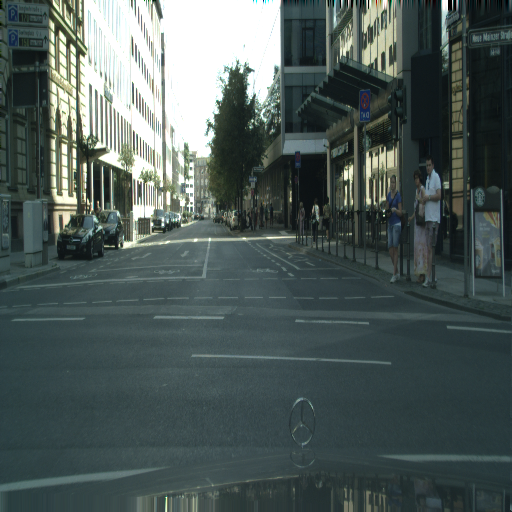
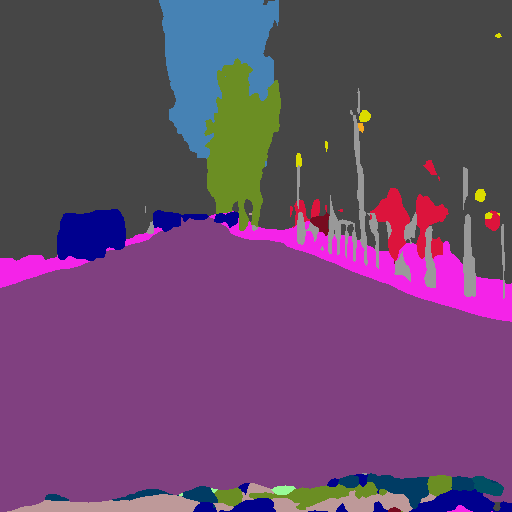
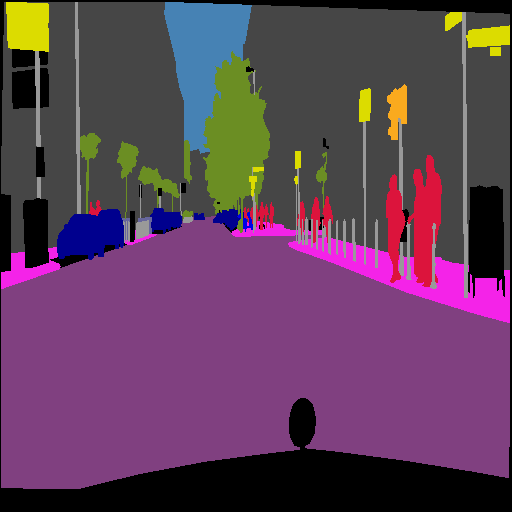

In [233]:
from torch import nn
import torch.nn.functional as F
# Define a module that transforms: RGB-channel image -> len(classes)-channel image

model = DeepLab()
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/DeeplabX_e65.pth"))

# Train the passthrough network
print("Testing training process...")
trainer = Trainer(model, ds_split)
trainer.fit(epochs=4, batch_size=20)

# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b:
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

In [234]:

torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/DeeplabX_e69.pth')
# model.load_state_dict(torch.load(os.path))